# 02_PyTorch_Neural_Network_Classification Exercises

## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.


In [325]:
# Imports that we need
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd
import numpy as np
import torchmetrics

# Create Device agnostic code 
if torch.cuda.is_available():
    device = torch.device("cuda") # If CUDA is available, use GPU
else:
    device = torch.device("cpu") # If CUDA is not available, use CPU

print(device)

cuda


In [326]:
# Create data
n_samples = 1000 # Number of samples to generate
random_state = 42 # Random state for reproducibility

X, y = make_moons(n_samples=n_samples, # Generate a two-dimensional dataset in the form of two interleaving half circles
                  noise=0.2, # Add some noise to the data
                  random_state=random_state)

len(X), len(y)


(1000, 1000)

In [327]:
X[0], y[0]  # Show the first 5 samples of data and labels

(array([-0.11166654,  0.52022374]), np.int64(1))

In [328]:
# Create dataframe from the generated data
moons = pd.DataFrame({"X0": X[:, 0], # First feature
                      "X1": X[:, 1], # Second feature
                      "label": y}) # Labels
 
moons.head(10)

,X0,X1,label
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0
5,0.662510,-0.084356,1
6,0.274510,-0.189904,1
7,-0.115556,0.535912,1
8,1.572369,-0.335447,1
9,0.763990,0.962359,0


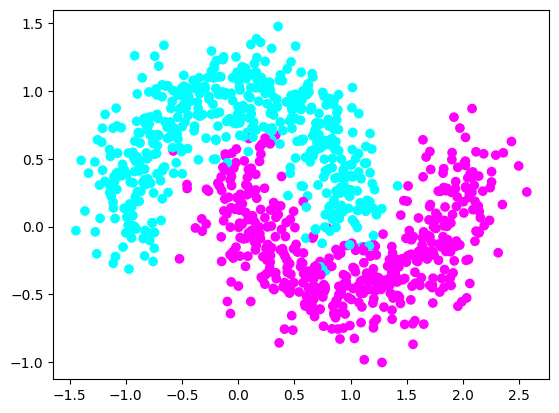

In [329]:
# Visualize the dataframe
plt.scatter(x=moons["X0"], # Plot the first feature on the x-axis
            y=moons["X1"], # Plot the second feature on the y-axis
            c=y,
            cmap="cool",)

In [330]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [331]:
# Create train and test splits

X_train, X_test, y_train, y_test = train_test_split(X, # Creates train and test splits of features
                                                    y, # Creates train and test splits of labels
                                                    test_size=0.2, # 20% of the data will be used for testing
                                                    random_state=random_state) # Set random state for reproducibility

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

* Feel free to use any combination of PyTorch layers (linear and non-linear) you w

In [332]:
# Create model 
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
    
        # Create layers
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=16) # 2 input features, 16 output features
    
        self.layer_2 = nn.Linear(in_features=16,
                                 out_features=16) # 116 input features, 16 output feature
    
        self.layer_3 = nn.Linear(in_features=16,
                                 out_features=1) # 16 input features, 1 output feature
    
        self.relu = nn.ReLU() # Create ReLU activation function

    def forward(self, x:torch.tensor) -> torch.tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_0 = MoonModelV0().to(device) # Create model instance and send it to device

model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [333]:
# loss function
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss function

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # update the parameters of model_0
                            lr=0.1) # learning rate of 0.1 

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.*


In [334]:
# accuracy function
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import MulticlassAccuracy

# setup accuracy metric
accuracy = BinaryAccuracy().to(device) * 100 # MUltiply by 100 to get percentage

# Setup multi-class accuracy metric
accuracy_multi = MulticlassAccuracy(num_classes=3).to(device) * 100 # Multiply by 100 to get percentage


In [335]:
# Create training & testing loop

# How many loops through the data
epochs = 400 

# Bring data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model_0.to(device) 

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze() # Forward pass through the model, squeeze to remove extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probabilities -> labels

    # 2. calculathe loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. back propagation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> probabilities -> labels

        # 2. calculate test loss & test accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Acc: {acc:.4f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68 | Acc: 54.1250% | Test Loss: 0.68184 | Test Acc: 57.50%
Epoch: 10 | Loss: 0.65 | Acc: 70.7500% | Test Loss: 0.65076 | Test Acc: 70.50%
Epoch: 20 | Loss: 0.62 | Acc: 79.1250% | Test Loss: 0.61616 | Test Acc: 80.50%
Epoch: 30 | Loss: 0.57 | Acc: 80.7500% | Test Loss: 0.57282 | Test Acc: 77.50%
Epoch: 40 | Loss: 0.51 | Acc: 81.6250% | Test Loss: 0.52004 | Test Acc: 77.50%
Epoch: 50 | Loss: 0.46 | Acc: 82.0000% | Test Loss: 0.46759 | Test Acc: 78.50%
Epoch: 60 | Loss: 0.41 | Acc: 82.3750% | Test Loss: 0.42563 | Test Acc: 79.50%
Epoch: 70 | Loss: 0.38 | Acc: 83.0000% | Test Loss: 0.39456 | Test Acc: 79.50%
Epoch: 80 | Loss: 0.36 | Acc: 83.2500% | Test Loss: 0.37123 | Test Acc: 79.50%
Epoch: 90 | Loss: 0.34 | Acc: 84.1250% | Test Loss: 0.35273 | Test Acc: 81.00%
Epoch: 100 | Loss: 0.32 | Acc: 85.1250% | Test Loss: 0.33750 | Test Acc: 82.00%
Epoch: 110 | Loss: 0.31 | Acc: 85.5000% | Test Loss: 0.32470 | Test Acc: 83.00%
Epoch: 120 | Loss: 0.30 | Acc: 86.2500% | Test Loss

## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [336]:
model_0.eval() # Set model to evaluation mode
with torch.inference_mode():
    y_logits_preds = model_0(X_test).squeeze() # Forward pass through the model



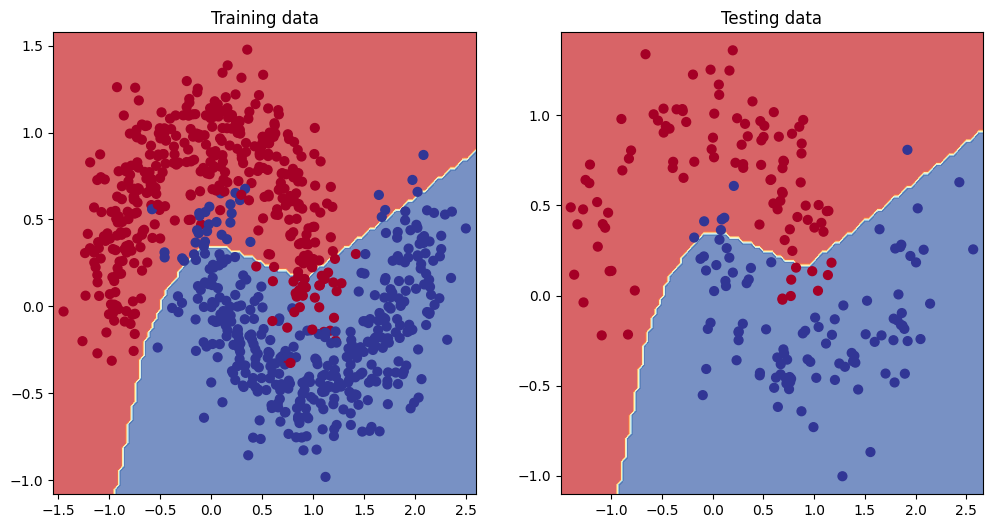

In [337]:
# Import function to plot decision boundary
from helper_functions import plot_decision_boundary

# Plot data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training data")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing data")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

* Feel free to reference the ML cheatsheet website for the formula: *https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh*


In [338]:
# Create test variable
torch.manual_seed(1337) # Set random seed for reproducibility
input = torch.randn(2, device=device) # Generate random tensor with 2 elements on the device

input

tensor([-0.2143, -0.5001], device='cuda:0')

In [339]:
# Pytorch Tanh function
m = nn.Tanh()

Py_output = m(input)

Py_output

tensor([-0.2111, -0.4622], device='cuda:0')

In [340]:
# Custom tanh function
def Tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

My_output = Tanh(input)

My_output

tensor([-0.2111, -0.4622], device='cuda:0')

In [341]:
# Does my output match PyTorch's output?
My_output == Py_output

tensor([False, False], device='cuda:0')

In [342]:
My_output.dtype, Py_output.dtype

(torch.float32, torch.float32)

In [343]:
Py_output.shape, My_output.shape


(torch.Size([2]), torch.Size([2]))

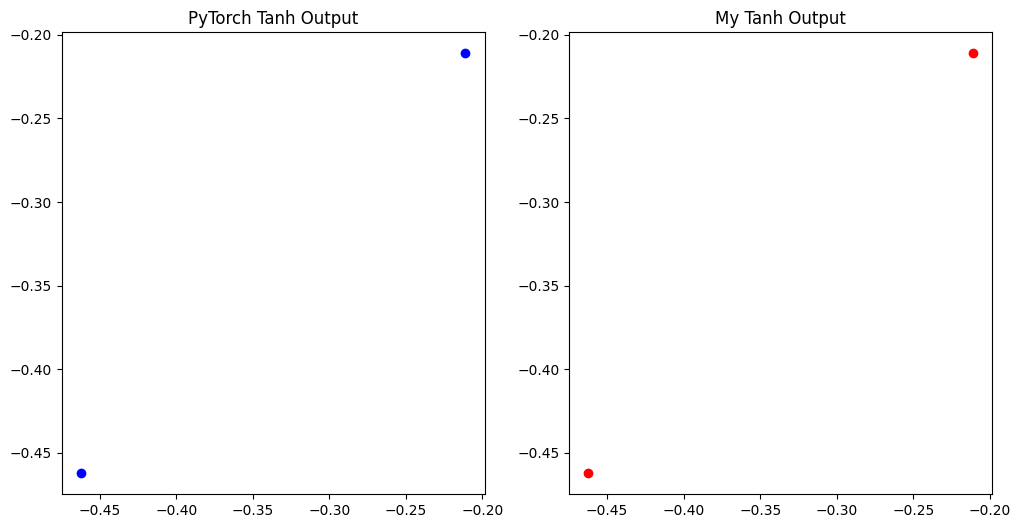

In [344]:
# Visualize the outputs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("PyTorch Tanh Output")
plt.scatter(Py_output.cpu().numpy(), Py_output.cpu().numpy(), color='blue', label='PyTorch Output')
plt.subplot(1, 2, 2)
plt.title("My Tanh Output")
plt.scatter(My_output.cpu().numpy(), My_output.cpu().numpy(), color='Red', label='My Output')

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.


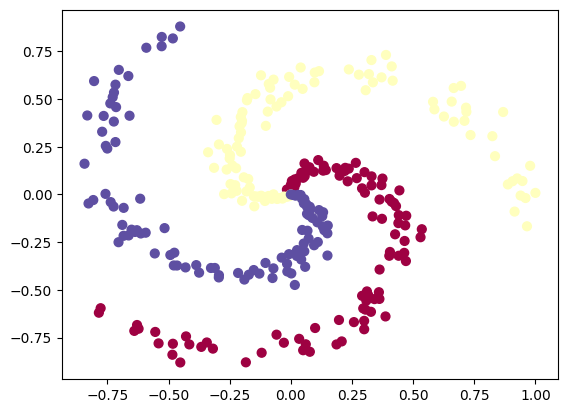

In [345]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [346]:
# Turning data into tensors of the correct dtype
TX = torch.from_numpy(X).type(torch.float) # numby likes float 64, pytorch wants float 32
Ty = torch.from_numpy(y).type(torch.LongTensor) # LongTensor for multi-class classification


In [347]:
TX, Ty

(tensor([[-0.0000e+00,  0.0000e+00],
         [-2.2544e-04,  1.0098e-02],
         [ 6.4394e-03,  1.9148e-02],
         [-1.5938e-02,  2.5773e-02],
         [ 1.4403e-02,  3.7750e-02],
         [ 3.8044e-04,  5.0504e-02],
         [ 2.0190e-02,  5.7144e-02],
         [ 4.3828e-03,  7.0571e-02],
         [ 1.6370e-02,  7.9133e-02],
         [ 3.0677e-02,  8.5577e-02],
         [ 5.0505e-02,  8.7477e-02],
         [ 5.6616e-02,  9.5605e-02],
         [ 4.3241e-02,  1.1324e-01],
         [ 5.6591e-02,  1.1849e-01],
         [ 6.8204e-02,  1.2388e-01],
         [ 9.3971e-02,  1.1885e-01],
         [ 7.6087e-02,  1.4259e-01],
         [ 5.5954e-02,  1.6235e-01],
         [ 1.3222e-01,  1.2480e-01],
         [ 1.4311e-01,  1.2788e-01],
         [ 1.3468e-01,  1.5058e-01],
         [ 1.1206e-01,  1.8011e-01],
         [ 1.9925e-01,  9.8392e-02],
         [ 1.8685e-01,  1.3806e-01],
         [ 2.3246e-01,  6.8799e-02],
         [ 2.2043e-01,  1.2321e-01],
         [ 2.2256e-01,  1.3943e-01],
 

In [348]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(TX,
                                                    Ty,
                                                    test_size=0.2,
                                                    random_state=1337)

len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [349]:
X_train.dtype, y_train.dtype  # Show the first 5 samples of data and labels

(torch.float32, torch.int64)

In [357]:
X_test.dtype, y_test.dtype

(torch.float32, torch.int64)

In [ ]:
# model for multi-class classification
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
    
        # Create layers
        self.layer_1 = nn.Linear(in_features=2, # number of dimensions of data NOT classes
                                 out_features=16) # 2 input features, 16 output features
    
        self.layer_2 = nn.Linear(in_features=16,
                                 out_features=16) # 16 input features, 16 output feature
    
        self.layer_3 = nn.Linear(in_features=16,
                                 out_features=3) # 16 input features, 1 output feature
    
        self.relu = nn.ReLU() # Create ReLU activation function
    
    def forward(self, x:torch.tensor) -> torch.tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
# Create model instance
model_1 = SpiralModel().to(device)
model_1
    


SpiralModel(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

In [352]:
# Create loss 
loss_fn = nn.CrossEntropyLoss() # Cross Entropy Loss for multi-class classification

# Create optimizer
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=0.1)

In [353]:
# Random seed for reproducibility
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)

# Bring data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model_1.to(device)

# How many loops through the data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. forward pass
    y_logits = model_1(X_train) # Forward pass through the model, squeeze to remove extra dimensions
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # Applying softmax over the labels in dim=1 then taking the argmax over dim=1

    # 2. Calculate the loss (& accuracy)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_multi(y_pred, y_train)

    # 3. optimmizer zero grad
    optimizer.zero_grad()

    # 4. back propagation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calcuate test loss & test accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_multi(test_pred, y_test)

    # print whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Acc: {acc:.4f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.11 | Acc: 33.3333% | Test Loss: 1.05906 | Test Acc: 51.36%
Epoch: 100 | Loss: 0.02 | Acc: 99.1661% | Test Loss: 0.01317 | Test Acc: 100.00%
Epoch: 200 | Loss: 0.02 | Acc: 99.1661% | Test Loss: 0.00772 | Test Acc: 100.00%
Epoch: 300 | Loss: 0.02 | Acc: 99.1661% | Test Loss: 0.00370 | Test Acc: 100.00%
Epoch: 400 | Loss: 0.01 | Acc: 99.1661% | Test Loss: 0.00398 | Test Acc: 100.00%
Epoch: 500 | Loss: 0.01 | Acc: 99.1661% | Test Loss: 0.00186 | Test Acc: 100.00%
Epoch: 600 | Loss: 0.01 | Acc: 99.1661% | Test Loss: 0.00144 | Test Acc: 100.00%
Epoch: 700 | Loss: 0.01 | Acc: 99.1661% | Test Loss: 0.00263 | Test Acc: 100.00%
Epoch: 800 | Loss: 0.01 | Acc: 99.1661% | Test Loss: 0.00170 | Test Acc: 100.00%
Epoch: 900 | Loss: 0.01 | Acc: 99.1768% | Test Loss: 0.00312 | Test Acc: 100.00%


In [358]:
X_train.shape, X_test.shape

(torch.Size([240, 2]), torch.Size([60, 2]))

In [355]:
y_train.shape, y_test.shape

(torch.Size([240]), torch.Size([60]))

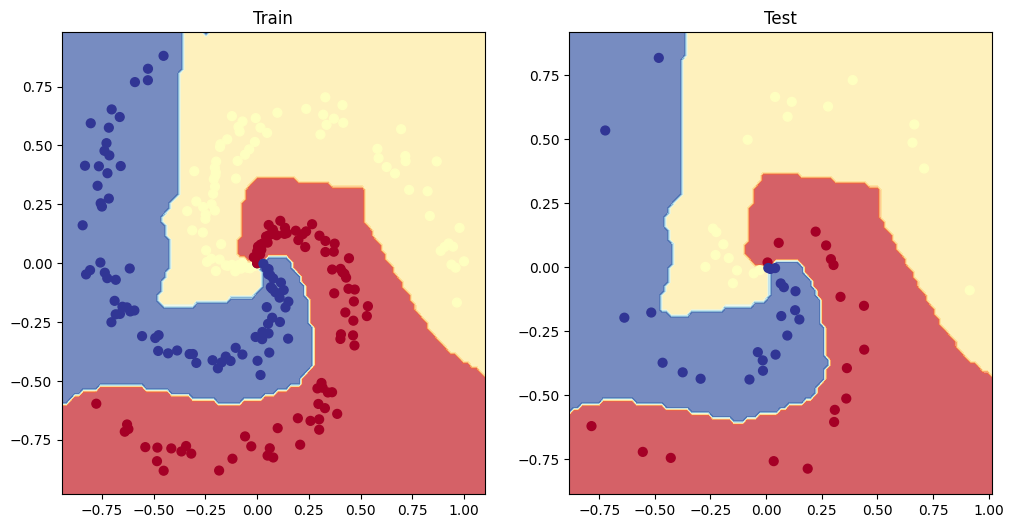

In [356]:
# Plot decision boundary
plt.figure(figsize=(12, 6)) # figure(figsize=(width & height in inches))
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
plt.title("Train") # Plot title
plot_decision_boundary(model_1, X_train, y_train) # Plot training data
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) # Makes predictions on the test data
